### Imports

In [ ]:
import os
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np 

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

from mlxtend.data import loadlocal_mnist

from google.colab import drive

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.7.0+cu101
True
True


In [ ]:
# google colab setting
#drive.mount('/content/drive/',force_remount = True)
#os.chdir('/content/drive/My Drive/DL_assignement')
data_dir ='./Data'


Mounted at /content/drive/


### 0.7 Putting this together : Building a VAE

In [ ]:
## Parameters 
BS = 64
N_TRAIN = 50000
N_VAL = 10000
N_EPOCHS = 80
VAL_SPLIT = 0.1
np.random.seed(123)
IMAGE_SIZE = 28
NB_CHANNELS = 1
NB_IM = 60000

#### Importing MNIST data 

You need to download the data from Lecun's website http://yann.lecun.com/exdb/mnist/ and place it into a folder called 'Data'

In [ ]:
!gunzip ./Data/train-images.idx3-ubyte.gz
!gunzip ./Data/train-labels.idx3-ubyte.gz

gzip: ./Data/train-images.idx3-ubyte.gz: No such file or directory
gzip: ./Data/train-labels.idx3-ubyte.gz: No such file or directory


In [ ]:
 # load data and labels as arrays
 X, Y = loadlocal_mnist(
            images_path= data_dir + '/train-images-idx3-ubyte', 
            labels_path=data_dir + '/train-labels-idx1-ubyte')
 
 print('Data size: ',X.shape[0])


X = X/255
Y = Y/255
X,Y = torch.Tensor(X), torch.Tensor(Y)


Data size:  60000


In [ ]:
dataset = torch.utils.data.TensorDataset(X,Y)                                       


# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=BS, 
                                           sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(dataset,
                                         batch_size= BS,
                                         sampler = valid_sampler)
print('Training set size : ', len(train_loader)*BS)
print('Validation set size : ', len(val_loader)*BS)

Training set size :  54016
Validation set size :  6016


### Plot sample

Batch shape:  torch.Size([64, 784])

Output label tensor shape:  torch.Size([64])


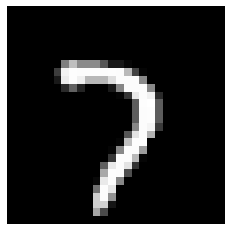

In [ ]:
single_batch = next(iter(train_loader))
print("Batch shape: ",single_batch[0].shape)
print("\nOutput label tensor shape: ", single_batch[1].shape)
im = single_batch[0][0]
plt.imshow(im.numpy().reshape((28,28)), cmap ='gray')
plt.axis('off')
plt.show()

### Building model

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.enc_mu = nn.Linear(h_dim1, z_dim)
        self.enc_log_sigma = nn.Linear(h_dim1, z_dim)
        # decoder part
        self.fc3 = nn.Linear(z_dim, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        x = F.relu(self.fc1(x))
        return self.enc_mu(x), self.enc_log_sigma(x) # mu, log_var
    
    def sampling(self, mu, log_var):
        sigma = torch.exp(0.5*log_var)
        return  mu + sigma * torch.randn_like(mu) # return z sample
        
    def decoder(self, x):
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        z = self.sampling(mu, log_sigma)
        return self.decoder(z), mu, log_sigma

# build model
vae = VAE(x_dim=784, h_dim1= 512, z_dim=20)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (enc_mu): Linear(in_features=512, out_features=20, bias=True)
  (enc_log_sigma): Linear(in_features=512, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:

def loss_function(recon_x, x, mu, log_sigma):
    # return reconstruction error + KL divergence losses

    criterion = nn.BCEWithLogitsLoss(reduction = 'sum')
    BCE = criterion(recon_x, x)
    #BCE = torch.pow(x - recon_x, 2).sum()
    KL_divergence = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp()) 
  
    return (BCE + KL_divergence)/x.size(0)

In [ ]:
def plot_sample(single_batch,title):
  
  single_batch = torch.reshape(single_batch, shape = (BS, NB_CHANNELS,IMAGE_SIZE, IMAGE_SIZE))
  fig = plt.figure(figsize = (8,8))
  single_batch_grid = torchvision.utils.make_grid(single_batch, nrow=8)
  plt.imshow(single_batch_grid.permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')
  plt.show()
  fig.savefig(title.replace(' ','_')+'.png')


def train(epoch, EXP_PATH):
  
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_sigma = vae(data)
        if batch_idx == 1:
          if epoch == 1:
            plot_sample(data.detach().cpu(),'Sample before training')

          if epoch in [10,80]:
         
            plot_sample(recon_batch.detach().cpu(),EXP_PATH +'/Reconstructed sample at epoch '+str(epoch))

        loss = loss_function(recon_batch, data, mu, log_sigma)
        loss.backward()
        train_loss += loss.item()*data.size(0)
        optimizer.step()
        
        if batch_idx % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader)*BS,
                100. * batch_idx / (len(train_loader)*BS), loss.item()))
            
    print('Epoch: {}/{} Average train loss: {:.4f}'.format(epoch, N_EPOCHS, train_loss / (len(train_loader)*BS)))

def val(epoch):

    vae.eval()
    val_loss = 0

    for batch_idx, (data, _) in enumerate(val_loader):

        data= data.cuda()
        recon_batch, mu, log_sigma = vae(data)
        loss = loss_function(recon_batch, data, mu, log_sigma)
        val_loss += loss.item()*data.size(0)
            
    print('Average val loss: {:.4f}'.format(val_loss /(len(val_loader)*BS)))


Train Epoch: 1 [0/54016 (0%)]	Loss: 233.891449


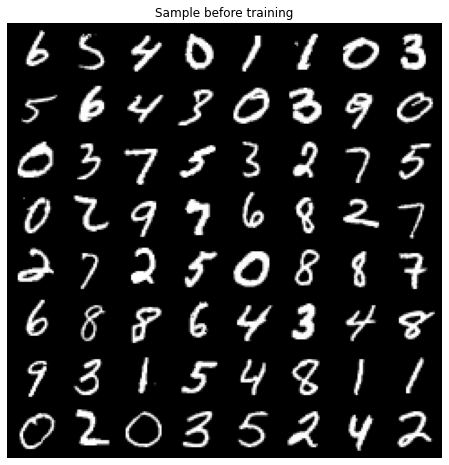

Train Epoch: 1 [19200/54016 (1%)]	Loss: 127.861259
Train Epoch: 1 [38400/54016 (1%)]	Loss: 125.037277
Epoch: 1/80 Average train loss: 126.0452
Average val loss: 125.4388
Train Epoch: 2 [0/54016 (0%)]	Loss: 113.762726
Train Epoch: 2 [19200/54016 (1%)]	Loss: 123.727470
Train Epoch: 2 [38400/54016 (1%)]	Loss: 118.580856
Epoch: 2/80 Average train loss: 125.4024
Average val loss: 124.5625
Train Epoch: 3 [0/54016 (0%)]	Loss: 129.296600
Train Epoch: 3 [19200/54016 (1%)]	Loss: 122.773682
Train Epoch: 3 [38400/54016 (1%)]	Loss: 130.255402
Epoch: 3/80 Average train loss: 125.0521
Average val loss: 125.0586
Train Epoch: 4 [0/54016 (0%)]	Loss: 127.846527
Train Epoch: 4 [19200/54016 (1%)]	Loss: 130.391708
Train Epoch: 4 [38400/54016 (1%)]	Loss: 118.986366
Epoch: 4/80 Average train loss: 125.2338
Average val loss: 124.6776
Train Epoch: 5 [0/54016 (0%)]	Loss: 124.311668
Train Epoch: 5 [19200/54016 (1%)]	Loss: 124.961891
Train Epoch: 5 [38400/54016 (1%)]	Loss: 129.048630
Epoch: 5/80 Average train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 10 [0/54016 (0%)]	Loss: 120.964500


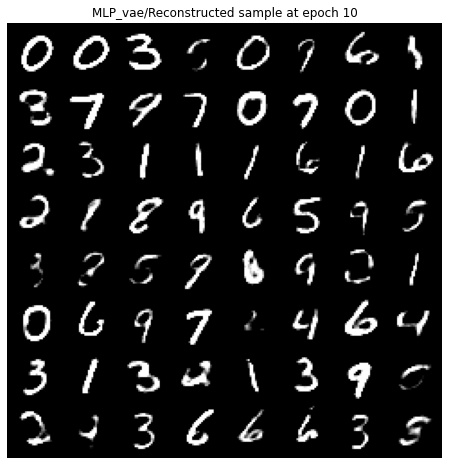

Train Epoch: 10 [19200/54016 (1%)]	Loss: 120.890221
Train Epoch: 10 [38400/54016 (1%)]	Loss: 122.929985
Epoch: 10/80 Average train loss: 124.7906
Average val loss: 125.5594
Train Epoch: 11 [0/54016 (0%)]	Loss: 128.057449
Train Epoch: 11 [19200/54016 (1%)]	Loss: 123.119705
Train Epoch: 11 [38400/54016 (1%)]	Loss: 117.863052
Epoch: 11/80 Average train loss: 124.8400
Average val loss: 124.0511
Train Epoch: 12 [0/54016 (0%)]	Loss: 124.266533
Train Epoch: 12 [19200/54016 (1%)]	Loss: 119.674858
Train Epoch: 12 [38400/54016 (1%)]	Loss: 121.767616
Epoch: 12/80 Average train loss: 124.6889
Average val loss: 124.1712
Train Epoch: 13 [0/54016 (0%)]	Loss: 124.709305
Train Epoch: 13 [19200/54016 (1%)]	Loss: 132.993713
Train Epoch: 13 [38400/54016 (1%)]	Loss: 123.117950
Epoch: 13/80 Average train loss: 124.5675
Average val loss: 125.4043
Train Epoch: 14 [0/54016 (0%)]	Loss: 131.219803
Train Epoch: 14 [19200/54016 (1%)]	Loss: 122.837479
Train Epoch: 14 [38400/54016 (1%)]	Loss: 117.812302
Epoch: 14/80

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 80 [0/54016 (0%)]	Loss: 119.909103


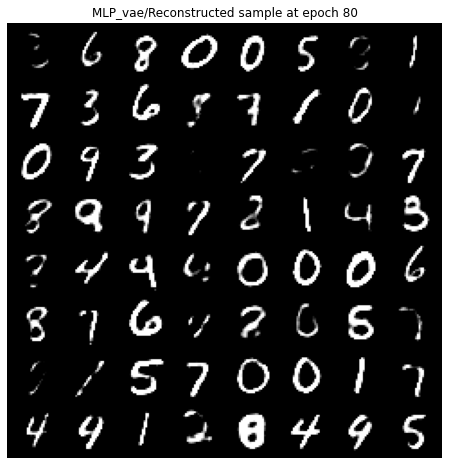

Train Epoch: 80 [19200/54016 (1%)]	Loss: 122.965385
Train Epoch: 80 [38400/54016 (1%)]	Loss: 120.876373
Epoch: 80/80 Average train loss: 124.7882
Average val loss: 125.0910


In [ ]:
optimizer = torch.optim.Adam(vae.parameters(),lr=1e-2)

EXP_PATH = 'MLP_vae'

for epoch in range(1, N_EPOCHS+1):
    train(epoch,EXP_PATH)
    val(epoch)


### Convolutional VAE

In [ ]:
 X, Y = loadlocal_mnist(
            images_path= data_dir + '/train-images-idx3-ubyte', 
            labels_path=data_dir + '/train-labels-idx1-ubyte')
 
 print('Data size: ',X.shape[0])


X = X/255
Y = Y/255
X,Y = torch.Tensor(X), torch.Tensor(Y)

X = torch.reshape(X, shape = (NB_IM, NB_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
dataset = torch.utils.data.TensorDataset(X,Y)                                       


# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=BS, 
                                           sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(dataset,
                                         batch_size= BS,
                                         sampler = valid_sampler)
print('Training set size : ', len(train_loader)*BS)
print('Validation set size : ', len(val_loader)*BS)

Data size:  60000
Training set size :  54016
Validation set size :  6016


In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=20):
        super(CVAE, self).__init__()

        # encoder layers
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=3, stride=1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, h_dim)
        self.enc_mu = nn.Linear(h_dim, z_dim)
        self.enc_log_sigma = nn.Linear(h_dim, z_dim)

        # decoder layers
        self.fc2 = nn.Linear(z_dim, 32*7*7)
        self.upsample = nn.Upsample(scale_factor = (2,2))
        self.convt1 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding = 1)
        self.convt2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding = 1)
        self.convt3 = nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1, padding = 1)       

        
    def encoder(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = self.fc1(x)

        return self.enc_mu(x), self.enc_log_sigma(x) # mu, log_var
    
    def sampling(self, mu, log_var):
        sigma = torch.exp(0.5*log_var)
        return  mu + sigma * torch.randn_like(mu) # return z sample
        
    def decoder(self, x):
        x = F.relu(self.fc2(x))
        x = torch.reshape(x,(x.size(0), 32,7,7 ))
        x = self.upsample(F.relu(self.convt1(x)))
        x = self.upsample(F.relu(self.convt2(x)))
        x = self.convt3(x)

        return x
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        z = self.sampling(mu, log_sigma)
        return self.decoder(z), mu, log_sigma

# build model
vae = CVAE(image_channels=1, h_dim=40, z_dim=20).cuda()


In [ ]:
vae

CVAE(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=40, bias=True)
  (enc_mu): Linear(in_features=40, out_features=20, bias=True)
  (enc_log_sigma): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1568, bias=True)
  (upsample): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (convt1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
summary(vae, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
           Flatten-5                 [-1, 3136]               0
            Linear-6                   [-1, 40]         125,480
            Linear-7                   [-1, 20]             820
            Linear-8                   [-1, 20]             820
            Linear-9                 [-1, 1568]          32,928
  ConvTranspose2d-10             [-1, 64, 7, 7]          18,496
         Upsample-11           [-1, 64, 14, 14]               0
  ConvTranspose2d-12           [-1, 32, 14, 14]          18,464
         Upsample-13           [-1, 32, 28, 28]               0
  ConvTranspose2d-14            [-1, 1,

Train Epoch: 1 [0/54016 (0%)]	Loss: 536.848389


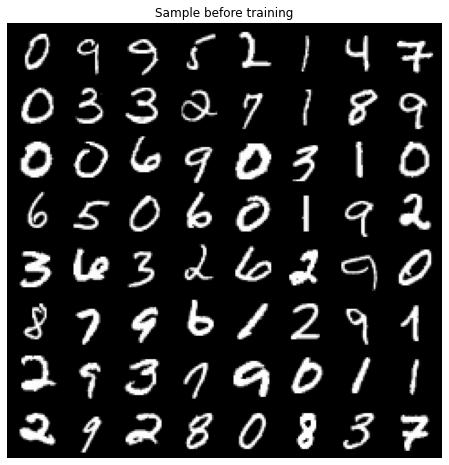

Train Epoch: 1 [19200/54016 (1%)]	Loss: 134.520706
Train Epoch: 1 [38400/54016 (1%)]	Loss: 123.036453
Epoch: 1/80 Average train loss: 145.3583
Average val loss: 117.1532
Train Epoch: 2 [0/54016 (0%)]	Loss: 117.764343
Train Epoch: 2 [19200/54016 (1%)]	Loss: 110.743706
Train Epoch: 2 [38400/54016 (1%)]	Loss: 111.251694
Epoch: 2/80 Average train loss: 112.4451
Average val loss: 109.4627
Train Epoch: 3 [0/54016 (0%)]	Loss: 114.070580
Train Epoch: 3 [19200/54016 (1%)]	Loss: 112.475983
Train Epoch: 3 [38400/54016 (1%)]	Loss: 105.884583
Epoch: 3/80 Average train loss: 107.6591
Average val loss: 106.1936
Train Epoch: 4 [0/54016 (0%)]	Loss: 108.536133
Train Epoch: 4 [19200/54016 (1%)]	Loss: 106.169113
Train Epoch: 4 [38400/54016 (1%)]	Loss: 103.595741
Epoch: 4/80 Average train loss: 105.4435
Average val loss: 104.7240
Train Epoch: 5 [0/54016 (0%)]	Loss: 98.271286
Train Epoch: 5 [19200/54016 (1%)]	Loss: 101.939072
Train Epoch: 5 [38400/54016 (1%)]	Loss: 104.447517
Epoch: 5/80 Average train loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average val loss: 101.4485
Train Epoch: 10 [0/54016 (0%)]	Loss: 100.644608


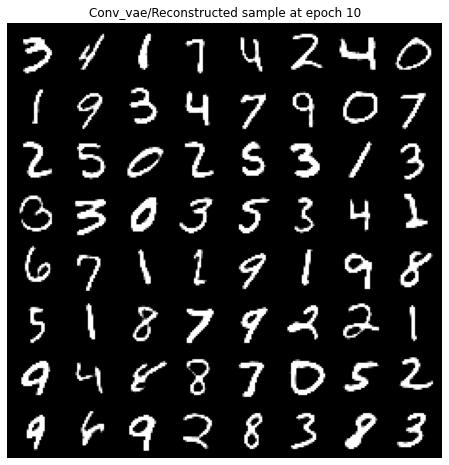

Train Epoch: 10 [19200/54016 (1%)]	Loss: 97.335838
Train Epoch: 10 [38400/54016 (1%)]	Loss: 101.556473
Epoch: 10/80 Average train loss: 100.9104
Average val loss: 101.1001
Train Epoch: 11 [0/54016 (0%)]	Loss: 103.879517
Train Epoch: 11 [19200/54016 (1%)]	Loss: 98.050034
Train Epoch: 11 [38400/54016 (1%)]	Loss: 106.094208
Epoch: 11/80 Average train loss: 100.4955
Average val loss: 100.8854
Train Epoch: 12 [0/54016 (0%)]	Loss: 101.242744
Train Epoch: 12 [19200/54016 (1%)]	Loss: 100.960640
Train Epoch: 12 [38400/54016 (1%)]	Loss: 103.690414
Epoch: 12/80 Average train loss: 100.2840
Average val loss: 100.5519
Train Epoch: 13 [0/54016 (0%)]	Loss: 104.667877
Train Epoch: 13 [19200/54016 (1%)]	Loss: 99.197891
Train Epoch: 13 [38400/54016 (1%)]	Loss: 97.050179
Epoch: 13/80 Average train loss: 100.0064
Average val loss: 100.3253
Train Epoch: 14 [0/54016 (0%)]	Loss: 93.639931
Train Epoch: 14 [19200/54016 (1%)]	Loss: 101.008110
Train Epoch: 14 [38400/54016 (1%)]	Loss: 100.877197
Epoch: 14/80 Aver

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average val loss: 96.8463
Train Epoch: 80 [0/54016 (0%)]	Loss: 98.838699


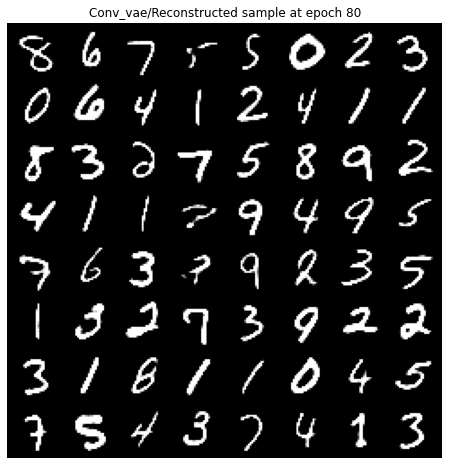

Train Epoch: 80 [19200/54016 (1%)]	Loss: 90.444054
Train Epoch: 80 [38400/54016 (1%)]	Loss: 97.747139
Epoch: 80/80 Average train loss: 95.9837
Average val loss: 96.6627


In [ ]:
optimizer = torch.optim.Adam(vae.parameters(),lr=1e-3)
EXP_PATH ='Conv_vae'

for epoch in range(1, N_EPOCHS+1):
    train(epoch,EXP_PATH)
    val(epoch)
